In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from math import sqrt
from numpy import split
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras_tuner import RandomSearch
from keras_tuner import Hyperband
from keras_tuner import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

In [2]:
import random
random.seed(123)

In [3]:
%run Funciones_Cons.ipynb

## Pruebas

In [4]:
def pruebas_mlp(interval, block, variable_mode, n_obs_antes, n_pred):
    res_time = interval
    edificio = block
    variables = variable_mode
    data = pd.read_csv('data-model-consumo' + edificio + '-' + res_time + '.csv', sep=";", index_col=0)
    
    if variables == 1:
        data = data[['dif_cons', 'V4']]
    else: 
        data = data.drop(columns='Fecha')
    df = data
    
    per_train = 0.7
    per_test = 0.15  
    train, test, val, scaler_x, scaler_y = split_dataset(df.values, per_train, per_test)
    
    n_input = n_obs_antes
    n_out = 1
    steps_pred = n_pred
    train_x, train_y = to_supervised(train, n_input, n_out, steps_pred)
    test_x, test_y = to_supervised(test, n_input, n_out, steps_pred)
    val_x, val_y = to_supervised(val, n_input, n_out, steps_pred)
    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], 1

    def build_model(hp):
        model = Sequential()
        #Numero de nodos en la primera capa 
        hp_units1 = hp.Choice('input_unit1',[25,50,100])
        model.add(Dense(units = hp_units1, input_shape=(n_timesteps, n_features)))
        hp_units2 = hp.Choice('input_unit2',[25,50,100])
        model.add(Dense(units = hp_units2))
        hp_dropout = hp.Float('Dropout_rate',min_value=0,max_value=0.4,step=0.1)
        model.add(Dropout(hp_dropout))
        model.add(Dense(1))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
        return model
    
    tuner= BayesianOptimization(build_model,
                                 objective='val_loss', max_trials=15, num_initial_points=2, seed = 123, overwrite=True)

    stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
    tuner.search(x=train_x, y=train_y, epochs=200, batch_size=128, validation_data=(val_x,val_y), verbose=2,
            shuffle=False, callbacks=[stop_early])
    model = tuner.get_best_models(num_models=1)[0]
    
    prediction = model.predict(test_x)
    prediction = prediction[:,n_input-1].reshape(prediction.shape[0],1)

    prediction = scaler_y.inverse_transform(prediction)
    test_y = scaler_y.inverse_transform(test_y)
    
    cvrmse, r2, rmse = metrics(test_y, prediction)
    
    return model, cvrmse, r2, rmse, test_y, prediction

In [5]:
obs_antes = [1,2,4]  #1,2,4
pred_steps = 1    #1
block = ['A','B','C']
interval = ['60T','120T']
var_mode = [1,2] #1 = dif_cons + V4, #2 = all

for i in block:
    for j in interval:
        for k in obs_antes:
            for l in var_mode:
                model, cvrmse, r2, rmse, test_y, prediction = pruebas_mlp(j, i, l, k, pred_steps)
                model.save('model_cons_mlp_' + i + '_0'+ str(l) + '_pred' + j + '_prev' + str(k) + '.h5')
                results_metrics = pd.read_csv('model-cons-results_metrics.csv', sep=";")
                add_metrics = {'Modelo': 'MLP', 'Edificio': i,'Variables': '0'+str(l), 'pred': j, 'n_obs_antes': k, 'CVRMSE': cvrmse, 'R2': r2, 'RMSE': rmse}
                results_metrics = results_metrics.append(add_metrics, ignore_index = True)
                results_metrics.to_csv('model-cons-results_metrics.csv', sep=";", index=False)
                results_preds = pd.read_csv('model-cons-results_preds.csv', sep=";")
                prediction = prediction.round(2)
                add_preds = pd.DataFrame({'Prueba': np.repeat('MLP-' + i + '-' + str(l) + '-' + j +'-' + str(k), len(test_y)),
                                        'test_y': test_y.tolist(),'prediction': prediction.tolist()})
                results_preds = pd.concat([results_preds, add_preds])
                results_preds.to_csv('model-cons-results_preds.csv', sep=";", index=False)

Trial 15 Complete [00h 00m 02s]
val_loss: 0.3718802332878113

Best val_loss So Far: 0.36765751242637634
Total elapsed time: 00h 01m 16s
INFO:tensorflow:Oracle triggered exit


In [253]:
# results_metrics = pd.DataFrame(columns=['Modelo', 'Edificio', 'Variables', 'pred', 'n_obs_antes', 'CVRMSE', 'R2', 'RMSE'])
# results_metrics
# results_metrics.to_csv('model-cons-results_metrics.csv', sep=";", index=False)
# results_preds = pd.DataFrame(columns=['Prueba', 'test_y', 'prediction'])
# results_preds
# results_preds.to_csv('model-cons-results_preds.csv', sep=";", index=False)

## Explicaciones

In [221]:
res_time = '60T'
edificio = 'A'

In [222]:
data = pd.read_csv('data-model-consumo' + edificio + '-' + res_time + '.csv', sep=";", index_col=0)
data = data.drop(columns='Fecha')
print(data.shape)
data.head(3)

(7049, 23)


,dif_cons,V2,V4,V12,V26,V5_0,V5_1,V5_2,Hora_1,Hora_2,...,Season_3,Season_4,tmed,hrmed,radmed,vvmed,dvmed,prec,dewpt,dpv
0,12.08,20.90,4.0,23.47,0.2,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,4.9,88.2,45.9,0.5,211.7,0.1,3.1,0.1
1,9.54,20.99,4.0,23.47,0.2,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,5.1,88.4,42.3,0.4,211.8,0.1,3.3,0.1
2,8.83,20.97,4.0,23.47,0.2,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,5.3,88.6,52.7,0.6,212.8,0.2,3.6,0.1


In [223]:
data = data[['dif_cons', 'V4']]

In [224]:
data.describe()

,dif_cons,V4
count,7049.000000,7049.000000
mean,5.244476,7.726344
std,2.790009,2.630939
min,0.450000,3.000000
25%,3.100000,6.000000
50%,4.710000,8.000000
75%,6.970000,9.000000
max,20.350000,16.000000


In [225]:
df = data

In [226]:
def split_dataset(data, per_train, per_test):
    train = data[0:int(np.ceil(df.shape[0]*per_train))]
    val = data[int(np.ceil(df.shape[0]*per_train)): int(np.ceil(df.shape[0]*(per_train+per_test)))]
    test = data[int(np.ceil(df.shape[0]*(per_train+per_test))):]
    #Escalado en train y test por separado. Si no se hace aquí ya no se puede porque todo lo que sigue es con arrays 3D
    scaler_y = StandardScaler()
    train_y = scaler_y.fit_transform(train[:,0].reshape(-1, 1))
    val_y = scaler_y.fit_transform(val[:,0].reshape(-1, 1))
    test_y = scaler_y.transform(test[:,0].reshape(-1, 1))
    scaler_x = StandardScaler()
    train_x = scaler_x.fit_transform(train[:,1:]) 
    val_x = scaler_x.fit_transform(val[:,1:]) 
    test_x = scaler_x.transform(test[:,1:])
    
    #Rehacemos los DataFrames con los datos escalados para poder hacer el split
    train = pd.concat([pd.DataFrame(train_y),pd.DataFrame(train_x)], axis=1)
    test = pd.concat([pd.DataFrame(test_y),pd.DataFrame(test_x)], axis=1)
    val = pd.concat([pd.DataFrame(val_y),pd.DataFrame(val_x)], axis=1)

    train = array(train)
    test = array(test)
    val = array(val)
    return train, test, val, scaler_x, scaler_y

In [227]:
# split en train y test
per_train = 0.7
per_test = 0.15
train, test, val, scaler_x, scaler_y = split_dataset(df.values, per_train, per_test)
print('shape: [muestras, pasos de tiempo, características]')
print('train shape:', train.shape)
print('val shape:', val.shape)
print('test shape:', test.shape)

shape: [muestras, pasos de tiempo, características]
train shape: (4935, 2)
val shape: (1057, 2)
test shape: (1057, 2)


In [228]:
def to_supervised(train, n_input, n_out, steps_pred):
    # Ponemos los datos en 2D: una entrada para cada muestra y paso de tiempo con las n características
    data = train#.reshape((train.shape[0]*train.shape[1], train.shape[2])) 
    X, y = list(), list()
    in_start = 0
    # Pasamos por todo el conjunto de datos, de step en step
    for _ in range(len(data)):
        # Definimos cuando empieza el input, cuando acaba, e igual para el output
        # En este caso el output empieza cuando acaba el input
        in_end = in_start + n_input
        out_end = in_end + n_out
        # Iteramos mientras haya ejemplos
        if out_end <= len(data):
            X.append(data[in_start:in_end, :]) # X son todas las variables en t
            y.append(data[in_end:out_end, 0])  # y es la temperatura en t+1 (si n_out=1) #AQUÍ SE DEFINE EL LAG
        # Pasamos al siguiente instante de tiempo
        in_start += steps_pred
    X = array(X)
    y = array(y)
    return X, y

In [229]:
#CAMBIAR N_INPUT ES EQUIVALENTE A CAMBIAR N_OBS_ANTES EN EL MODELO DE TEMPERATURA
n_input = 1
n_out = 1

In [230]:
train_x, train_y = to_supervised(train, n_input, n_out, 1)
test_x, test_y = to_supervised(test, n_input, n_out, 1)
val_x, val_y = to_supervised(val, n_input, n_out, 1)
#train_x = train_x.reshape(train_x.shape[0], train_x.shape[2])
#test_x = test_x.reshape(test_x.shape[0], test_x.shape[2])
#val_x = val_x.reshape(val_x.shape[0], val_x.shape[2])
print('train_x shape:' , train_x.shape) 
print('train_y shape:'  , train_y.shape)   
print('val_x shape:' , val_x.shape)  
print('val_y shape:' , val_y.shape) 
print('test_x shape:' , test_x.shape)  
print('test_y shape:' , test_y.shape)    

train_x shape: (4934, 1, 2)
train_y shape: (4934, 1)
val_x shape: (1056, 1, 2)
val_y shape: (1056, 1)
test_x shape: (1056, 1, 2)
test_y shape: (1056, 1)


In [231]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], 1
print('n_timesteps:' , n_timesteps) 
print('n_features:'  , n_features)     
print('n_outputs:' , n_outputs)   

n_timesteps: 1
n_features: 2
n_outputs: 1


In [232]:
def build_model(hp):
    model = Sequential()
    #Numero de nodos en la primera capa 
    hp_units1 = hp.Choice('input_unit1',[25,50,100])
    model.add(Dense(units = hp_units1, input_shape=(n_timesteps, n_features)))
    hp_units2 = hp.Choice('input_unit2',[25,50,100])
    model.add(Dense(units = hp_units2))
    hp_dropout = hp.Float('Dropout_rate',min_value=0,max_value=0.4,step=0.1)
    model.add(Dropout(hp_dropout))
    model.add(Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
    return model

In [233]:
tuner1= BayesianOptimization(
        build_model,
        objective='val_loss',
        max_trials=5,
        num_initial_points=2,
        seed = 123,
        overwrite=True
        )

In [234]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [235]:
#Si esto da un error que dice algo de Oracle, se arregla borrando los json que hay en /untitle_project
tuner1.search(
        x=train_x,
        y=train_y,
        epochs=100,
        batch_size=128,
        validation_data=(val_x,val_y),
        verbose=2,
        shuffle=False,
        callbacks=[stop_early]
)

Trial 5 Complete [00h 00m 06s]
val_loss: 0.14720648527145386

Best val_loss So Far: 0.14720648527145386
Total elapsed time: 00h 00m 22s
INFO:tensorflow:Oracle triggered exit


In [109]:
tuner1.results_summary(num_trials=1)

Results summary
Results in .\untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
input_unit1: 100
input_unit2: 25
Dropout_rate: 0.4
learning_rate: 0.0001
Score: 0.3773021101951599


In [236]:
model1 = tuner1.get_best_models(num_models=1)[0]

In [237]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 25)             75        
                                                                 
 dense_1 (Dense)             (None, 1, 100)            2600      
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 dense_2 (Dense)             (None, 1, 1)              101       
                                                                 
Total params: 2,776
Trainable params: 2,776
Non-trainable params: 0
_________________________________________________________________


In [23]:
#model1.save('model_cons_mlp_01_prev1_10T.h5')
#model1 = keras.models.load_model('model_cons_mlp_01_prev1_10T.h5')

In [34]:
def predict(datos_test_x, modelo):
    test_x = datos_test_x
    model = modelo
    #Creamos una lista vacía para las predicciones
    predictions = list()

    i=0
    j=0
    for i in range(len(test_x)):
        data = test_x[i,:]
        input_x = data.reshape(1,data.shape[0])
        #print(input_x)
        
        # Prediccion para cada paso de tiempo
        yhat = model.predict(input_x, verbose=0)
        yhat_sequence = yhat[0] 
        
        # Guardamos las predicciones
        predictions.append(yhat_sequence)
        
        # Reescribimos el valor de la temperatura del siguiente paso con la prediccion
        if j < len(test_x):
            try: 
                test_x[j+1,0] = yhat[0]
                #print(yhat[0])
            except IndexError: continue
        #else: break
    j+=1
        
    predictions = array(predictions)

    return predictions

In [96]:
prediction = predict(test_x, model1)

ValueError: cannot reshape array of size 2 into shape (1,1)

In [238]:
prediction = model1.predict(test_x)
prediction = prediction[:,n_input-1].reshape(prediction.shape[0],1)

In [239]:
prediction.shape

(1056, 1)

In [240]:
prediction = scaler_y.inverse_transform(prediction)
test_y = scaler_y.inverse_transform(test_y)

In [241]:
#SIN ACTUALIZAR
rmse = np.sqrt(mean_squared_error(test_y,prediction))
cvrmse = rmse/np.mean(test_y)*100
r2 = r2_score(test_y, prediction)
print('Test RMSE: %.3f' % rmse)
print('Test CVRMSE: %.3f' % cvrmse)
print('Test R squared: %.3f' % r2)

Test RMSE: 0.266
Test CVRMSE: 8.956
Test R squared: 0.937


In [46]:
#AGRUPANDO POR HORAS
pred = pd.DataFrame(prediction).groupby(pd.DataFrame(prediction).index // 6).mean()
real = pd.DataFrame(test_y).groupby(pd.DataFrame(test_y).index // 6).mean()
rmse = np.sqrt(mean_squared_error(real, pred))
r2 = r2_score(real, pred)
cvrmse = rmse/np.mean(real)*100
print('Test RMSE: %.3f' % rmse)
print('Test CVRMSE: %.3f' % cvrmse)
print('Test R squared: %.3f' % r2)

Test RMSE: 0.034
Test CVRMSE: 6.874
Test R squared: 0.974


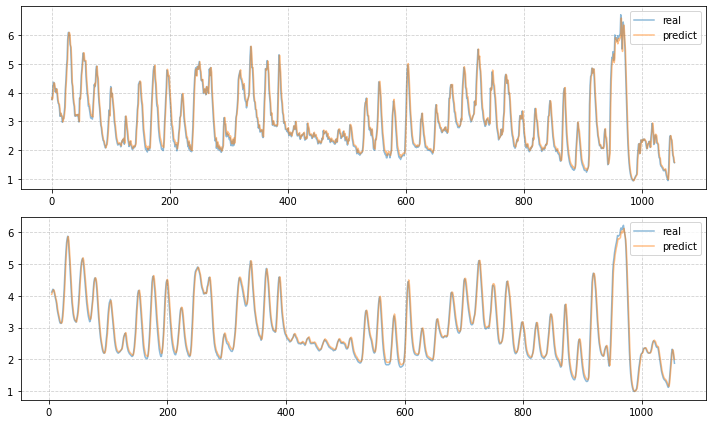

In [161]:
#EDIFICIO A SIN ACTUALIZAR
fig, axs = plt.subplots(figsize=(10,6), nrows = 2, ncols =1, sharex =False)
#fig = plt.figure(figsize =(15, 5))
axs[0].plot(test_y, label='real',alpha=0.5)
axs[0].plot(prediction, label='predict', alpha=0.5)
axs[0].grid(linestyle = "--", alpha=0.6)
axs[0].legend()
#Media móvil por horas
axs[1].plot(pd.DataFrame(test_y).rolling(6).mean(), label='real',alpha=0.5)
axs[1].plot(pd.DataFrame(prediction).rolling(6).mean(), label='predict', alpha=0.5)
axs[1].grid(linestyle = "--", alpha=0.6)
axs[1].legend()
fig.tight_layout()
plt.show()

In [43]:
#ACTUALIZANDO
rmse = np.sqrt(mean_squared_error(test_y,prediction))
cvrmse = rmse/np.mean(test_y)*100
r2 = r2_score(test_y, prediction)
print('Test RMSE: %.3f' % rmse)
print('Test CVRMSE: %.3f' % cvrmse)
print('Test R squared: %.3f' % r2)

Test RMSE: 3.044
Test CVRMSE: 26.053
Test R squared: -1.618


In [39]:
#AGRUPANDO POR HORAS
pred = pd.DataFrame(prediction).groupby(pd.DataFrame(prediction).index // 6).mean()
real = pd.DataFrame(test_y).groupby(pd.DataFrame(test_y).index // 6).mean()
rmse = np.sqrt(mean_squared_error(real, pred))
r2 = r2_score(real, pred)
cvrmse = rmse/np.mean(real)*100
print('Test RMSE: %.3f' % rmse)
print('Test CVRMSE: %.3f' % cvrmse)
print('Test R squared: %.3f' % r2)

Test RMSE: 8.732
Test CVRMSE: 74.735
Test R squared: -22.950


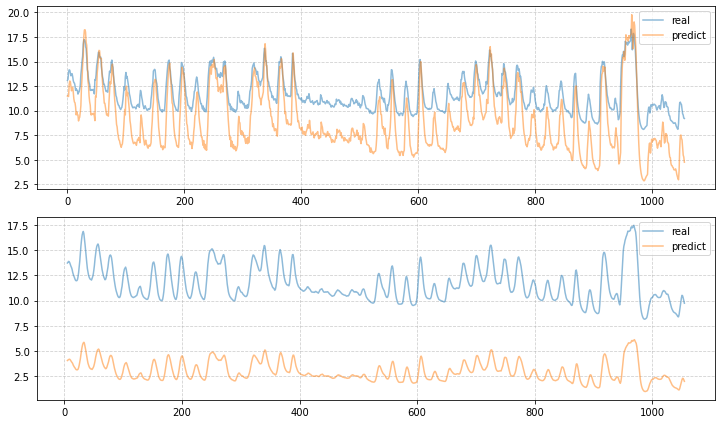

In [41]:
#EDIFICIO A ACTUALIZANDO
fig, axs = plt.subplots(figsize=(10,6), nrows = 2, ncols =1, sharex =False)
#fig = plt.figure(figsize =(15, 5))
axs[0].plot(test_y, label='real',alpha=0.5)
axs[0].plot(prediction, label='predict', alpha=0.5)
axs[0].grid(linestyle = "--", alpha=0.6)
axs[0].legend()
#Media móvil por horas
axs[1].plot(pd.DataFrame(test_y).rolling(6).mean(), label='real',alpha=0.5)
axs[1].plot(pd.DataFrame(prediction).rolling(6).mean(), label='predict', alpha=0.5)
axs[1].grid(linestyle = "--", alpha=0.6)
axs[1].legend()
fig.tight_layout()
plt.show()

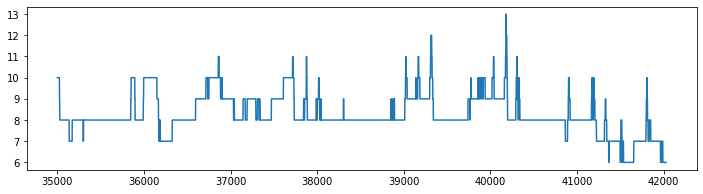

In [51]:
fig = plt.figure(figsize=(12,3))
plt.plot(data['V4'][35000:])